# Capstone Project - The Battle of the Neighborhoods (Week 2)

### Table of Contents

* [1. Introduction](#intro)
    * [1.1 Background](#1_1)
    * [1.2 Business Problem](#1_2)
    * [1.3 Interest](#1_3)
* [2. Data Acquisition and Cleaning](#data)
    * [2.1 Data Sources](#2_1)
    * [2.2 Data Cleaning](#2_2)
* [3. Methodology](#methodology)
    * [3.1 Exploratory Data Analysis](#3_1)
    * [3.2 Methodology to find the ideal neighborhood for a specific client](#3_2)
    * [3.3 Machine Learning](#3_3)
    * [3.4 Cluster Analysis](#3_4)
* [4. Results and Discussion](#r&c)
* [5. Conclusion](#Conclusion)
    
    

    
   

## Introduction <a class="anchor" id="intro"></a>

### 1.1 Background <a class="anchor" id="1_1"></a>

Toronto is the capital of the province of Ontario and one of the most densely populated cities in Canada. The current metro area population of Toronto in 2020 is 6,197,000. 

Being one of the top housing markets in Canada competition between real estate agencies is high. The ability to find the ideal property for their client is key for them to increase their sales. 

For most real estate agencies and their clients, it boils down to budget when choosing a neighborhood in Toronto. 

However, the ideal property for a client is not only the one that falls within their budget, but it should also be in a neighborhood that matches the client’s lifestyle and preferences.


### 1.2 Business Problem <a class="anchor" id="1_2"></a>

This project will leverage Foursquare location and venue data to find neighborhoods that best match a client’s preferences and lifestyle. 

To improve the quality of a real estate agency’s offerings and provide tailormade choices for their clients considering lifestyle and not only their budget. 

### 1.3 Interest <a class="anchor" id="1_3"></a>

This project is targeted towards Toronto real estate agencies interested in having better quality offerings to attract more clients.

### Data Acquisition and Cleaning <a class="anchor" id="data"></a>

### 2.1 Data Sources <a class="anchor" id="2_1"></a>

•	Data on Postal Code, Boroughs and Neighborhoods in Canada will be scrapped from Wikipedia:https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M and converted into a data frame for analysis.

•	Data on geographical coordinates will be read form a preprepared CSV file: http://cocl.us/Geospatial_data_ and converted into a data frame for analysis.

•	Data on venues around a given location will be collected through Foursquare’s API

### 2.2 Data Cleaning <a class="anchor" id="2_2"></a>

First, we will get the data on postal codes in Canada

In [1]:
## Intsalling and importing libraries needed
#!pip install pandas lxml beautifulsoup4 html5lib matplotlib -U
import sys
import pandas as pd

print(f"Python version {sys.version}")
print(f"pandas version: {pd.__version__}")

Python version 3.7.9 (default, Aug 31 2020, 12:42:55) 
[GCC 7.3.0]
pandas version: 1.0.5


**The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood**

_We will Scrape Data from Wikipedia_

In [2]:
Scrapped_Table = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
Scrapped_df=pd.DataFrame(Scrapped_Table[0])

In [3]:
Scrapped_df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


We will only proces cells that have an assigned borough, and ignore cells with a borough that is Not assigned.

In [4]:
df=Scrapped_df[Scrapped_df.Borough!='Not assigned'].reset_index(drop=True)

_Note: More than one neighborhood can exist in one postal code area.They will be separated by a coma on the dataframe as show below for **Regent Park, Harbourfront**_ 

In [5]:
df.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Now that we have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to use the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.

Data will be read from a preprepared CSV file

In [6]:
geo=pd.read_csv('http://cocl.us/Geospatial_data')

In [7]:
geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


We will merge both dataframes 

In [8]:
df_geo=pd.merge(df,geo, on='Postal Code')

In [9]:
df_geo.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Our data frame has information on all postal codes in Canada, we want to narrow it down to postal codes in Toronto only.

So we will work only with boroughs that contain the word Toronto

In [10]:
Toronto_df=df_geo[df_geo['Borough'].astype(str).str.contains('Toronto')].reset_index(drop=True)

In [11]:
Toronto_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [12]:
Toronto_df.shape

(39, 5)

We will define Foursquare Credentials and Version in the following hidden cell

In [13]:
# @hidden_cell
CLIENT_ID = 'B52PSHKYVHJEKGPHNSXGDTODJQXGQACSXTLVSDJGG0KMRSIU' # your Foursquare ID
CLIENT_SECRET = 'MJEG0HW5O2INASIQW4RYATWH4QZ2VYXNZNQHXLAVEAI3AWHB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: B52PSHKYVHJEKGPHNSXGDTODJQXGQACSXTLVSDJGG0KMRSIU
CLIENT_SECRET:MJEG0HW5O2INASIQW4RYATWH4QZ2VYXNZNQHXLAVEAI3AWHB


## 3. Methodology  <a class="anchor" id="methodology"></a>

### 3.1 Exploratory Data Analysis <a class="anchor" id="3_1"></a>

We will install and import libraries needed for the analysis

In [14]:
!pip install folium

     |████████████████████████████████| 93 kB 2.5 MB/s  eta 0:00:01


In [15]:
!pip install geopy

In [16]:
import numpy as np # library to handle data in a vectorized manner

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
print('Libraries imported.')

Libraries imported.


### Visualizing neighborhoods in Toronto on a map

We will get geographical coordinates for Toronto

In [17]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.6534817, -79.3839347.


Map of Toronto with neighborhoods over it

In [18]:
# create map of Toronto df using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(Toronto_df['Latitude'], Toronto_df['Longitude'], Toronto_df['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### We will create a function to explore venues for all the neighborhoods in Toronto using the Foursquare API

In [19]:
#function to get nearby venues for all the neighborhoods in Toronto
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We will create a new dataframe for all the venues in each neighborhood

In [20]:
toronto_venues = getNearbyVenues(names=Toronto_df['Neighbourhood'],
                                   latitudes=Toronto_df['Latitude'],
                                   longitudes=Toronto_df['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

In [21]:
print(toronto_venues.shape)
toronto_venues.head()

(1622, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


### How many unique categories can be curated from all the returned venues?

In [22]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 236 uniques categories.


We will use one hot encoding to organize the categories for each neighborhood 

In [23]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0

In [24]:
toronto_onehot.shape

(1622, 236)

Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [25]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.017544,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.0000,0.017544,0.035088,0.000000,0.000000,0.00,0.017544,0.017544,0.000000,0.035088,0.000000,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.017544,0.017544,0.000000,0.0000,0.000000,0.035088,0.000000,0.000000,0.000000,0.00,0.017544,0.052632,0.087719,0.000000,0.00000,0.00000,0.000000,0.00,0.000000,0.017544,0.000000,0.017544,0.000000,0.000000,0.000000,0.017544,0.000000,0.000000,0.000000,0.000

In [26]:
toronto_grouped.shape

(39, 236)

### 3.2 Methodology to find the ideal neighborhood for a specific client <a class="anchor" id="3_2"></a>

### Defining the metrics:

The real estate agency will interview clients to pick their top 5 preferred venue categories for their ideal neighborhood and create client's profile. For example:

**Client 1**<br>
Name: Mark Leonard<br>
Top 5 venue categories:<br>
1.Coffee Shop<br>
2.Restaurant<br>
3.Bar<br>
4.Gym<br>
5.Nightclub<br>

Based on their Top 5 venue categories we will create a "lifestyle score" using the frequencies of occurrence of each category in each neighborhood from the previous table (toronto_grouped).

The higher the lifestyle score the more of the preferred venues that neighborhood has.

We will find the ideal neighborhood for **Client 1: Mark Leonard**

**First, we will define a function that returns the "lifestyle score" for each neighborhood taking the client's 5 preferred venue categories as an input.**

In [27]:
#function to get the lifestyle score for each neighborhood 
def Lifestyle_score(cat1,cat2,cat3,cat4,cat5):
    L=[]
    for x in range(39):
        v1=toronto_grouped._get_value(x,cat1) 
        v2=toronto_grouped._get_value(x,cat2) 
        v3=toronto_grouped._get_value(x,cat3) 
        v4=toronto_grouped._get_value(x,cat4) 
        v5=toronto_grouped._get_value(x,cat5)
        lifestyle_score=(v1+v2+v3+v4+v5)
        L.append([toronto_grouped._get_value(x, 'Neighborhood'),lifestyle_score])
        
    Lifestyle_s = pd.DataFrame(L, columns=['Neighborhood','Lifestyle score'])
    return Lifestyle_s

### Lifestyle score for Client 1

In [28]:
#Calling the function and passing the top 5 preffered venue categories as parameters
LS_Client1=Lifestyle_score('Coffee Shop','Restaurant','Bar','Gym','Nightclub') 

We will display the resulting dataframe sorted by lifestyle score in descending order

In [29]:
LS_Client1.sort_values('Lifestyle score',ascending=False)

,Neighborhood,Lifestyle score
23,"Queen's Park, Ontario Provincial Government",0.281250
20,"Moore Park, Summerhill East",0.250000
1,"Brockton, Parkdale Village, Exhibition Place",0.240000
7,"Commerce Court, Victoria Hotel",0.230000
22,"Parkdale, Roncesvalles",0.214286
33,"Summerhill West, Rathnelly, South Hill, Forest...",0.214286
19,"Little Portugal, Trinity",0.204545
11,"First Canadian Place, Underground city",0.190000
5,Christie,0.187500
25,"Richmond, Adelaide, King",0.185567


## 3.3 Machine Learning <a class="anchor" id="3_3"></a>

### K-Means Clustering

Using K-Means we will cluster neighborhoods based on the neighborhoods that have similar averages of lifestyle score for that client.

To get the optimum value for **K** and avoid overfitting or underfitting our model, we will use the **Elbow Point Technique.** We run a test with different values of K and measure accuracy for each. To the choose the best value for K, we identify the point where the line has the sharpest change of direction. 

We will import **‘KElbowVisualizer’** from the Yellowbrick package to apply this technique. Then we will fit our K-Means model to the Elbow visualizer.

In [30]:
# Intalling and importing libraries
!pip install yellowbrick

     |████████████████████████████████| 269 kB 10.0 MB/s eta 0:00:01


In [31]:
from sklearn.cluster import KMeans
import numpy as np
from yellowbrick.cluster import KElbowVisualizer

### Elbow Point Visualizer

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


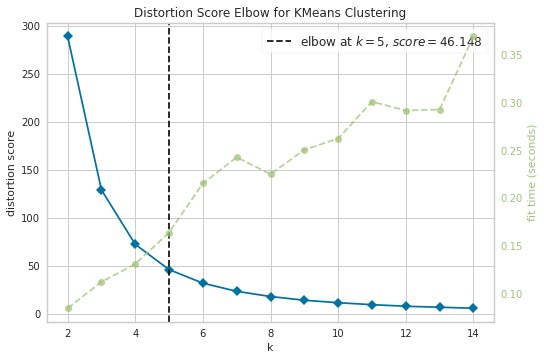

In [32]:
x = np.random.random(13876)

km = KMeans()

visualizer=KElbowVisualizer(km,k=(2,15))
x = np.random.random(13876)

visualizer.fit(x.reshape(-1,1)) 
visualizer.show()

From the graph we can identify the **Elbow Point at K=5.** Therefore, we will have a total of **5 clusters** in our model.

In [33]:
# setting number of clusters
kclusters = 5

toronto_grouped_clustering = LS_Client1.drop('Neighborhood', 1)

# running k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# checking cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

x = np.random.random(13876)

km = KMeans()
km.fit(x.reshape(-1,1)) 

KMeans()

**We will modify the dataframe to include cluster labels and lifestyle score**

In [34]:
# adding clustering labels
LS_Client1.insert(0, 'Cluster Labels', kmeans.labels_)

In [35]:
LS_Client1.head()

,Cluster Labels,Neighborhood,Lifestyle score
0,2,Berczy Park,0.122807
1,0,"Brockton, Parkdale Village, Exhibition Place",0.240000
2,1,"Business reply mail Processing Centre, South C...",0.062500
3,2,"CN Tower, King and Spadina, Railway Lands, Har...",0.117647
4,3,Central Bay Street,0.177419


We will create a new dataframe joining the dataframe that has the cluster labels and lifestyle score with the one that has geographical information on each neighborhood 

In [36]:
df_toronto =Toronto_df.rename(columns={'Neighbourhood': 'Neighborhood'})

Neighborhoods_Client1=pd.merge(df_toronto,LS_Client1,on='Neighborhood')

In [37]:
Neighborhoods_Client1.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Lifestyle score
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,3,0.173913
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,0.281250
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,2,0.120000
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,2,0.123457
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,4,0.000000


## 3.4 Cluster Analysis <a class="anchor" id="3_4"></a>

By getting the average lifestyle score of each cluster and number of neighborhoods we can get a broad view of our clusters before analyzing them one by one.

In [38]:
#function to get the average lifestyle score of each cluster
def Avg_Lifestyle_score():
    Avg=[]
    for x in range(5):
        temp=Neighborhoods_Client1.loc[Neighborhoods_Client1['Cluster Labels'] == x, Neighborhoods_Client1.columns[[1] + list(range(5, Neighborhoods_Client1.shape[1]))]]
        Avgs=temp['Lifestyle score'].mean()
        Avg.append([x,Avgs])
    AvgLifestyle_s = pd.DataFrame(Avg, columns=['Cluster Labels','Average Lifestyle score'])
    return AvgLifestyle_s

In [39]:
#Calling function
Average_clusters=Avg_Lifestyle_score()

**Dataframe for Average Lifestyle score by cluster**

In [40]:
Average_clusters

,Cluster Labels,Average Lifestyle score
0,0,0.238304
1,1,0.069459
2,2,0.127444
3,3,0.179010
4,4,0.000000


**Bar plot:**

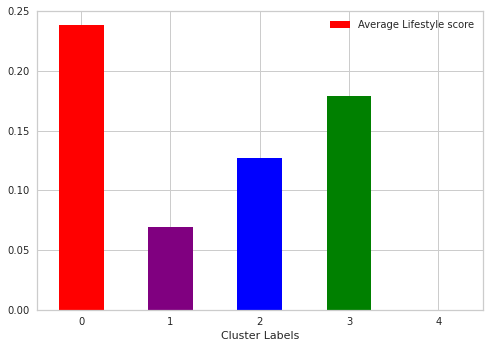

In [41]:
df=Average_clusters.plot.bar(x='Cluster Labels',y='Average Lifestyle score',rot=0,color=['red','purple','blue','green','orange'])

In [42]:
#function to count the number of neighborhoods in each cluster
def Count_Neighborhoods_in_Cluster():
    C=[]
    for x in range(5):
        temp=Neighborhoods_Client1.loc[Neighborhoods_Client1['Cluster Labels'] == x, Neighborhoods_Client1.columns[[1] + list(range(5, Neighborhoods_Client1.shape[1]))]]
        Counts=temp['Cluster Labels'].count()
        C.append([x,Counts])
        Count_Neighborhoods = pd.DataFrame(C, columns=['Cluster Labels','Number of Neighborhoods'])
    return Count_Neighborhoods

In [43]:
#Calling function
Count_Neighborhoods=Count_Neighborhoods_in_Cluster()

**Dataframe for the number of neighborhoods by cluster**

In [44]:
Count_Neighborhoods

,Cluster Labels,Number of Neighborhoods
0,0,6
1,1,4
2,2,13
3,3,10
4,4,6


**Bar Plot:**

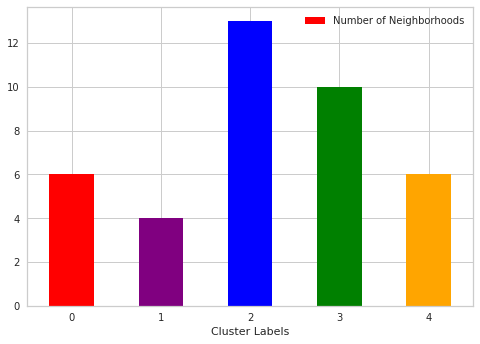

In [45]:
Count_plot=Count_Neighborhoods.plot.bar(x='Cluster Labels',y='Number of Neighborhoods',rot=0,color=['red','purple','blue','green','orange'])

From the bar plots above we can see **Cluster 0** has the highest average lifestyle score and only 6 neighborhoods, while **Cluster 2** has the third highest average lifestyle score and has the highest number of neighborhoods(12); and **Cluster 4** has the lowest average lifestyle score(0)

**We will now examine our clusters to see the neighborhoods on each one**

### Cluster 0

In [46]:
Neighborhoods_Client1.loc[Neighborhoods_Client1['Cluster Labels'] == 0]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Lifestyle score
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,0.281250
14,M6K,West Toronto,"Brockton, Parkdale Village, Exhibition Place",43.636847,-79.428191,0,0.240000
16,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,0,0.230000
25,M6R,West Toronto,"Parkdale, Roncesvalles",43.648960,-79.456325,0,0.214286
29,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,0,0.250000
31,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049,0,0.214286


### Cluster 1

In [47]:
Neighborhoods_Client1.loc[Neighborhoods_Client1['Cluster Labels'] == 1]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Lifestyle score
12,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,1,0.093023
22,M6P,West Toronto,"High Park, The Junction South",43.661608,-79.464763,1,0.041667
30,M5T,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049,1,0.080645
38,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,1,0.062500


### Cluster 2

In [48]:
Neighborhoods_Client1.loc[Neighborhoods_Client1['Cluster Labels'] == 2]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Lifestyle score
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,2,0.120000
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,2,0.123457
5,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,2,0.122807
9,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259,2,0.133333
15,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,2,0.142857
17,M4M,East Toronto,Studio District,43.659526,-79.340923,2,0.111111
24,M5R,Central Toronto,"The Annex, North Midtown, Yorkville",43.672710,-79.405678,2,0.150000
26,M4S,Central Toronto,Davisville,43.704324,-79.388790,2,0.138889
27,M5S,Downtown Toronto,"University of Toronto, Harbord",43.662696,-79.400049,2,0.121212
28,M6S,West Toronto,"Runnymede, Swansea",43.651571,-79.484450,2,0.128205


### Cluster 3

In [49]:
Neighborhoods_Client1.loc[Neighborhoods_Client1['Cluster Labels'] == 3]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Lifestyle score
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,3,0.173913
6,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,3,0.177419
7,M6G,Downtown Toronto,Christie,43.669542,-79.422564,3,0.187500
8,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,3,0.185567
10,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,3,0.180000
11,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,3,0.204545
13,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,3,0.170000
23,M4R,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678,3,0.157895
34,M5W,Downtown Toronto,Stn A PO Boxes,43.646435,-79.374846,3,0.163265
36,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,3,0.190000


### Cluster 4

In [50]:
Neighborhoods_Client1.loc[Neighborhoods_Client1['Cluster Labels'] == 4]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Lifestyle score
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,4,0.0
18,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,4,0.0
19,M5N,Central Toronto,Roselawn,43.711695,-79.416936,4,0.0
20,M4P,Central Toronto,Davisville North,43.712751,-79.390197,4,0.0
21,M5P,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",43.696948,-79.411307,4,0.0
33,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,4,0.0


### We will now visualize our clusters on a map

In [51]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Neighborhoods_Client1['Latitude'], Neighborhoods_Client1['Longitude'], Neighborhoods_Client1['Neighborhood'], Neighborhoods_Client1['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters


**Cluster colors:**<br>
Cluster 0-Red<br>
Cluster 1-Purple<br>
Cluster 2-Blue<br>
Cluster 3-Green<br>
Cluster 4-Orange<br>

## 4. Results and Discussion  <a class="anchor" id="r&c"></a>

Our analysis shows that the ideal neighborhoods for **Client 1: Mark Leonard** are in **_Cluster 0_** since it has the **highest average lifestyle score.**

The neighborhoods in **Cluster 0** are:
- Queen's Park, Ontario Provincial Government
- Brockton, Parkdale Village, Exhibition Place
- Commerce Court, Victoria Hotel
- Parkdale, Roncesvalles
- Moore Park, Summerhill East
- Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park

Our search for the ideal property for our client should start in one of these neighborhoods and then go down the list of the other clusters in descending order acording to the average lifestyle score.

If we order the clusters by descending average lifestyle score the search would be in the following order:

1. **Cluster 0 (≈ 0.24)**<br>
2. Cluster 3 (≈ 0.18)<br>
3. Cluster 2 (≈ 0.13)<br>
4. Cluster 1 (≈ 0.07)<br>
5. Cluster 4 (0)<br>


## 5. Conclusion  <a class="anchor" id="Conclusion"></a>

The purpose of this project was to identify the ideal neighborhoods for a real estate’s client in Toronto based on their lifestyle and preferences. By identifying their client’s top 5 preferred venue categories and calculating a “lifestyle score” with the frequencies of those venues in each neighborhood (The higher the lifestyle score the more of the preferred venues that neighborhood has). 

Then we utilized K-Means to cluster neighborhoods based on the neighborhoods that have similar averages of lifestyle score for that client. With the results we were able to identify Cluster 0 as the group of neighborhoods that have the highest lifestyle score. 

The real estate agency can consider neighborhoods in Cluster 0 as the starting point for more detailed analysis in the search for their client’s property. They can then start narrowing down properties in those neighborhoods according to their client’s budget and also be confident that the recommended properties in those neighborhoods will satisfy their client’s lifestyle and preferences. Providing them with more wholesome recommendations. 
